<h3><strong>Hotel Cancellation Prediction Using Binary Classifier</strong></h3>

<p><i>Author: Mesuga, Reymond R.</i></p>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

<h3><strong>Plot Utilities</strong></h3>

In [4]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

<h3><strong>Data Preparation</strong></h3>

In [15]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')
hotel.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [16]:
X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
input_shape

[62]

<h3><strong>Defining the Model</strong></h3>
<p>The model that we'll be using will have both batch normalization and dropout layers.

The first layer will be the input data where the Batch Normalization is also applied. The two hidden layers were both contain of 256 units, ReLU Activation Function, Batch Normalization and Dropout Rate of 0.3.

The output layer will have 1 unit and a Sigmoid Activation Function.</p>

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

<h3><strong>Adding Optimizer, Loss, and Metric to the Model</strong><h3>
<p>We'll be adding the Adam optimizer and binary versions of cross-entropy and accuracy metric.</p>

In [45]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

<h3><strong>Training the Model</strong></h3>
<p>The early_stopping has been applied to the model during training to prevent the sudden increase of validation loss that causes the overfitting.
</p>

Epoch 1/300
175/175 [==============================] - 3s 7ms/step - loss: 0.5676 - binary_accuracy: 0.7242 - val_loss: 0.4402 - val_binary_accuracy: 0.7860
Epoch 2/300
175/175 [==============================] - 1s 6ms/step - loss: 0.4341 - binary_accuracy: 0.7979 - val_loss: 0.4078 - val_binary_accuracy: 0.8110
Epoch 3/300
175/175 [==============================] - 1s 6ms/step - loss: 0.4124 - binary_accuracy: 0.8076 - val_loss: 0.3967 - val_binary_accuracy: 0.8156
Epoch 4/300
175/175 [==============================] - 1s 6ms/step - loss: 0.4088 - binary_accuracy: 0.8105 - val_loss: 0.3894 - val_binary_accuracy: 0.8170
Epoch 5/300
175/175 [==============================] - 1s 6ms/step - loss: 0.4021 - binary_accuracy: 0.8130 - val_loss: 0.3853 - val_binary_accuracy: 0.8209
Epoch 6/300
175/175 [==============================] - 1s 6ms/step - loss: 0.3973 - binary_accuracy: 0.8130 - val_loss: 0.3823 - val_binary_accuracy: 0.8250
Epoch 7/300
175/175 [==============================] - 1s 

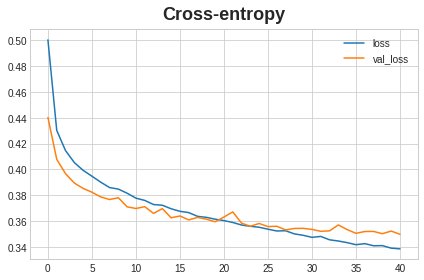

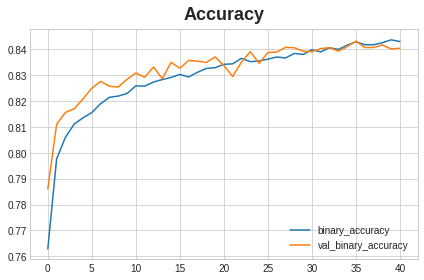

In [46]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=300,
    callbacks=[early_stopping],
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

<h3><strong>Conclusion</strong></h3>
<p>The model reaches an accuracy of approxiamtely 84% which is not bad for a simple binary classifier model. The author recommend making the model wider or deeper or adjust the values of some parameters and evaluate if the accuracy of the model increases.</p>